In [106]:
import os
import numpy as np
import pandas as pd 
import argparse
import logging
import sys
import operator
from hashlib import md5
from reedsolo import RSCodec
from math import ceil
from math import log, floor, sqrt
import random
import json
import numpy as np
from numpy.random import RandomState
import scipy.interpolate as inter
import math
import csv
from Fountain_Helpers import *
from Visual import * 
from FT_class import *
from Model_Helpers import *
from tqdm import tqdm
logging.getLogger().setLevel(logging.INFO)
from scipy import stats
import cv2 as cv
%load_ext autoreload
%autoreload 2

MASK_LENGTH = 32

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [121]:
lines = []
with open('freq.txt','r') as f:
    lines = f.readlines()
    f.close()
def parse_freq_line(line):
    line = line.split('\n')[0]
    line = line.replace('(','')
    line = line.replace('%)','')
    
    symbols = line.split(' ')
    char_num, freq = int(symbols[0]), float(symbols[-1])/100
    return char_num, freq
freq_dic = {}
for line in lines:
    char_num, freq = parse_freq_line(line)
    freq_dic[chr(char_num)] = freq
# freq_dic
for i in range(256):
    if chr(i) not in freq_dic:
        freq_dic[chr(i)] = 0
len(freq_dic)

256

In [122]:
freq_array = sorted(freq_dic.items(),key = lambda item: item[1],reverse=True)

In [123]:
for i in freq_array[:80]:
    print(i)

(' ', 0.171662)
('e', 0.085771)
('t', 0.0637)
('o', 0.057701)
('a', 0.051879999999999996)
('n', 0.049701)
('i', 0.04901900000000001)
('s', 0.043685999999999996)
('r', 0.042586000000000006)
('l', 0.03175)
('h', 0.027444000000000003)
('d', 0.025071)
('c', 0.021129)
('u', 0.020999)
('m', 0.016437)
('g', 0.015597000000000001)
('p', 0.015482000000000001)
('.', 0.015124)
('-', 0.013734)
('f', 0.013725000000000001)
('w', 0.013033999999999999)
('y', 0.01133)
('b', 0.010195000000000001)
('v', 0.008461999999999999)
(',', 0.007383999999999999)
('k', 0.006753)
('0', 0.005516)
('1', 0.004594)
(':', 0.004354)
('S', 0.004003)
('C', 0.003906)
('M', 0.003529)
('2', 0.003322)
('T', 0.003322)
('I', 0.003211)
('D', 0.0031509999999999997)
('A', 0.003132)
('E', 0.002673)
('P', 0.002614)
('W', 0.0025269999999999997)
('R', 0.002519)
("'", 0.002447)
('"', 0.002442)
('H', 0.002321)
(')', 0.002233)
('(', 0.002178)
('B', 0.002163)
('N', 0.002085)
('x', 0.0019500000000000001)
('L', 0.001884)
('G', 0.00187599999999

In [126]:
class Scanner:
    def __init__(self,max_repeat = 3, gc_interval = [0.45,0.55]):
        self.max_repeat = max_repeat
        self.gc_interval = gc_interval
        
    def scan_repeats(self,dna,record_position = False):
        repeats = []
        prv = dna[0]
        r_num = 1
        for i,c in enumerate(dna[1:]):
            if prv == c:
                r_num += 1
            else:
                if(r_num > self.max_repeat):
                    if(record_position):
                        repeats.append([prv,r_num,i-r_num+1])
                    else:
                        repeats.append([prv,r_num])
                r_num = 1
                prv = c

        if(r_num > self.max_repeat): 
                    if(record_position):
                        repeats.append([prv,r_num,i-r_num+1])
                    else:
                        repeats.append([prv,r_num])
        return repeats
    
    def max_repeats(self,dna):
        rs = self.scan_repeats(dna)
        if rs == []: return 0
        else: return max([r[1] for r in rs])
        
    def repeats_point(self,dna):
        rs = self.scan_repeats(dna)
        if rs == []: return 0
        else:
            return sum([r[1] / (self.max_repeat + 1) for r in rs])

    def Gc(self,dna):
        gc = dna.count('G') + dna.count('C')
        l = len(dna)
        return float(gc) / l
    
    def gc_pass(self,dna):
        if self.gc_interval[0]  < self.Gc(dna) < self.gc_interval[1]:
            return True
        else:
            return False
    
    def Pass(self,dna,with_primer = False):
        if self.gc_pass(dna) and self.repeats_point(dna)  == 0:
            return True
        else:
            return False
    
    def ave_gc(self,dnas):
        return sum([self.Gc(dna) for dna in dnas])/len(dnas)

    def rp_total(self,dnas):
        return(sum([self.repeats_point(dna) for dna in dnas]))

    def Entropy(self,labels, base=4):
        # 计算概率分布
        labels = list(labels)
        probs = pd.Series(labels).value_counts() / len(labels)
        # 计算底数为base的熵
        logging.debug(probs)
        en = stats.entropy(probs, base=base)
        return en
    
    def select_best(self,dnas):
        min_rp = 10000
        best_dna = dnas[0]
        for dna in dnas:
            if(self.gc_pass(dna)):
                if self.repeats_point(dna) < min_rp:
                    min_rp = self.repeats_point(dna)
                    best_dna = dna
        return best_dna,min_rp
                  

In [143]:
scn = Scanner(max_repeat=0)
def sort_with_rp(l):
    return sorted(l,key = lambda x:scn.max_repeats(x))

def gen_dna(l):
    re = [[] for i in range(l+1)]
    for i in range(4**l):
        dna = num_to_dna(i,l)
        gc = dna.count('C') + dna.count('G')
        re[gc].append(dna)
    return [sort_with_rp(r) for r in re]

dna_list = gen_dna(4)  
gc_mid = dna_list[2]
gc_low = dna_list[1] + dna_list[0]
gc_high = dna_list[3] + dna_list[4]

In [144]:
chr(188)

'¼'

In [145]:
def ave_gc(out_array):
    return sum([pair[1] * (pair[2].count('C') + pair[2].count('G')) for pair in out_array]) / sum([pair[1] for pair in out_array])
    

In [146]:
out_array = []
i  = 0 
gcs = []
for dna in gc_mid:
        out_array.append([freq_array[i][0],freq_array[i][1],dna])
        i += 1
        gcs.append(2)
        
l_index = 0
h_index = 0

while i < len(freq_array):
    if freq_array[i][1] == 0: break
    if ave_gc(out_array) > 0.5:
        out_array.append([freq_array[i][0],freq_array[i][1],gc_low[l_index]])
        i += 1
        l_index += 1
    else:
        out_array.append([freq_array[i][0],freq_array[i][1],gc_high[h_index]])
        i += 1
        h_index += 1

for dna in gc_low[l_index+1:] + gc_high[h_index+1:]:
    out_array.append([freq_array[i][0],freq_array[i][1],dna])
    i += 1
    gcs.append(ave_gc(out_array))
        

    

In [190]:
C2D= {}
D2C = {}
for pair in out_array:
    C2D[pair[0]] = pair[2]
    D2C[pair[2]] = pair[0]

In [195]:
l = [[o[0],o[2]] for o in out_array]

In [148]:
def encode_string(s):
    return ''.join([C2D[c] for c in s])
def decode_to_string(dna):
    return ''.join([D2C[d] for d in s])


In [186]:
def pre_process(file_name, chunk_size):
    try:
      f = open(file_name, 'rb')
    except: 
      logging.error("%s file not found", file_name)
      sys.exit(0)
    data = f.read()    
    original_size = os.path.getsize(file_name)

    pad = -len(data) % chunk_size
    if pad > 0:
      logging.debug("Padded the file with %d zero to have a round number of blocks of data", pad)    
    data += b'\0' * pad #zero padding.
    size = len(data)
    #divide into chunks

    chunk_num = int(size/chunk_size)
    data_array = [None]*chunk_num
    for num in range(chunk_num):
        start = chunk_size * num
        end = chunk_size * (num+1)
        chunk_binary = data[start:end]
        data_array[num] = chunk_binary
    f_in = data_array
    f_size = len(data)
    return f_in

In [187]:
data = pre_process('Visual.py',chunk_size = 20)
dnas = [byte_to_dna(d) for d in data]

In [181]:
dnas = [encode_string(str(d)) for d in data]

In [200]:
simpleTable(freq_array[0:100])

,property,value
0,,0.171662
1,e,0.085771
2,t,0.063700
3,o,0.057701
4,a,0.051880
5,n,0.049701
6,i,0.049019
7,s,0.043686
8,r,0.042586
9,l,0.031750


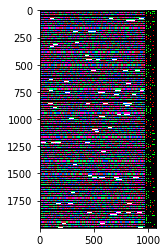

In [203]:
dnas = [random_dna(96) for i in range(100)]
p.draw_dnas_with_marks(dnas,'RND.png')

In [173]:
C = {
    'A': (0,0.4,1),
    'T': (0.8,0.2,0.2),
    'G': (1,0,0.8),
    'C': (0,1,0.4),
    'D': (1,1,1),
    'I': (0.8,0.8,0.4),
    'B': (0,0,0)
}

class dna_painter:
    def __init__(self,W = 10,H = 10):
        self.W = W
        self.H = H
        self.Line_width = int(H/3) + 1
        self.Line_spacing = int(H/2) + 1
        
    def rec(self,img,x,n,c,ins = 0):
        if ins == 1:
            cv.rectangle(img,(x*self.W,n*self.H),(x*self.W+self.W-1,n*self.H+self.H-1),C['I'],-1)
        else:
            cv.rectangle(img,(x*self.W,n*self.H),(x*self.W+self.W-1,n*self.H+self.H-1),c,-1)
    
    def line(self,img,x,n,l):
        cv.line(img,(x*self.W, n*self.H + self.Line_spacing),(x*self.W + l*self.W-1,n*self.H + self.Line_spacing),(1,1,1),self.Line_width)
    
    def draw_dna(self,img,dna,row = 0):
        for i,base in enumerate(dna):
            self.rec(img,i,row,C[base])
            
    def draw_text(self,img,text,x,n,c = (1,1,1)):
        
        cv.putText(img, text, (x * self.W,n * self.H+3), cv.FONT_HERSHEY_COMPLEX, 0.6, c, 1)

    def draw_dnas(self,dna_array,src = 'dna.png'):
        img = np.zeros([self.H*(len(dna_array) * 2 + 2),len(dna_array[0])*self.W,3])
        for i in range(len(dna_array)):
            self.draw_dna(img,dna_array[i],i*2)
        plt.imsave(src,img)
        
        return plt.imshow(img)
    
    def draw_dnas_with_marks(self,dna_array,src = 'dna_repeat.png', scanner = None):
        color = lambda b: (0,1,0) if b == True else (1,0,0)  
        self.scanner = scanner
        if scanner == None:
            self.scanner = Scanner()
        gcs = [[self.scanner.Gc(dna), self.scanner.gc_pass(dna)] for dna in dna_array]
        homos = [self.scanner.scan_repeats(dna,True) for dna in dna_array] 
        # get gc and rp
        
        img = np.zeros([self.H*(len(dna_array) * 2),(len(dna_array[0])+11)*(self.W),3])
        #init image
        
        for i in range(len(dna_array)):
            self.draw_dna(img,dna_array[i],i*2)
            for homo in homos[i]:
                l = homo[1]
                start = homo[2]
                self.line(img,start,i*2 + 1,l)
            self.draw_text(img,str(gcs[i][0])[:4],len(dna_array[0]) + 1, i*2+1, color(gcs[i][1]))
            if (homos[i] != []):
                self.draw_text(img,'rej',len(dna_array[0]) + 6, i*2+1, color(False))
            else:
                self.draw_text(img,'pas',len(dna_array[0]) + 6, i*2+1, color(True))
        plt.imsave(src,img)
        
        return plt.imshow(img)

    def draw_error(self,img,errors,row,num):
        for error in errors:
            x = error[0]
            typ = error[1]
            to = error[2]
            if(typ == '-'):
                to = 'D'
            if(typ != '+'):
                self.rec(img,x,row,C[to])
            else:
                self.rec(img,x,row,C[to],1)
        
p = dna_painter()
# p.draw_dnas_with_marks([d for d in encode_result])
# p.draw_dnas_with_marks([d for d in dnas],'ori.png')
# p.draw_dnas(m.masks)

In [37]:
scn.max_repeats('TATACA')

1